Importing modules

In [731]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
 
series = pd.read_csv('exchange_rate.csv', index_col=0, squeeze=True)
series = pd.DataFrame(series)
series.head()

,EUR/USD Close,USD/JPY Close,USD/CHF Close,GBP/USD Close,USD/CAD Close
Date,,,,,
1/9/2017,1.05649,116.156,1.01580,1.21543,1.32276
1/10/2017,1.05582,115.743,1.01654,1.21634,1.32240
1/11/2017,1.05750,115.465,1.01498,1.22060,1.31690
1/12/2017,1.06171,114.599,1.01040,1.21621,1.31357
1/13/2017,1.06455,114.533,1.00851,1.21843,1.31225


In [732]:
eur_usd = pd.DataFrame(series['EUR/USD Close'])
usd_jpy = pd.DataFrame(series['USD/JPY Close'])
usd_chf = pd.DataFrame(series['USD/CHF Close'])
gbp_usd = pd.DataFrame(series['GBP/USD Close'])
usd_cad = pd.DataFrame(series['USD/CAD Close'])

val = gbp_usd['GBP/USD Close']

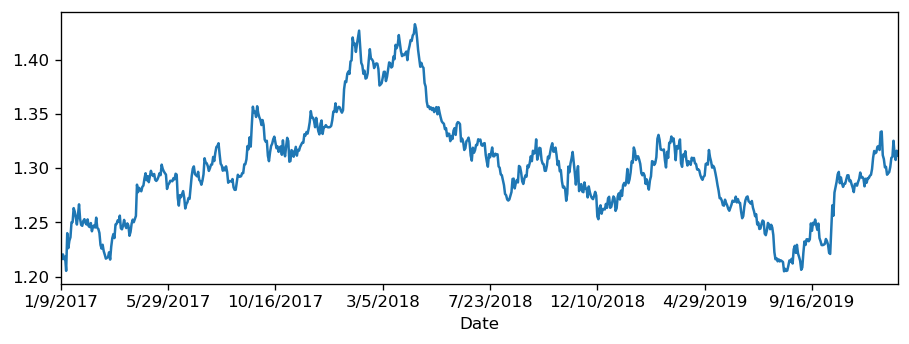

In [733]:
val.plot();

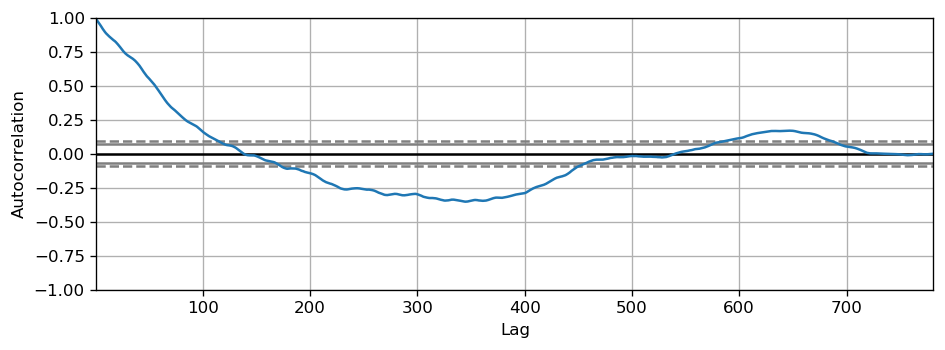

In [734]:
pd.plotting.autocorrelation_plot(val)
pyplot.show()

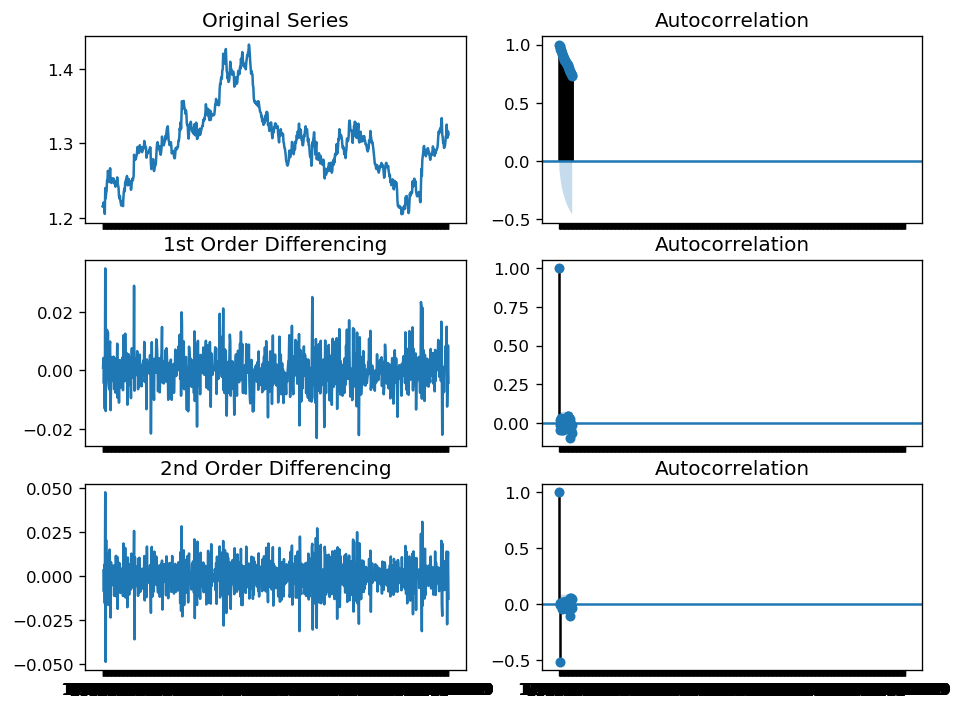

In [735]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(val); axes[0, 0].set_title('Original Series')
plot_acf(val, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(val.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(val.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(val.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(val.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [745]:
# ARIMA Model
model = ARIMA(val, order=(3,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:          GBP/USD Close   No. Observations:                  781
Model:                     ARMA(3, 1)   Log Likelihood                2797.138
Method:                       css-mle   S.D. of innovations              0.007
Date:                Wed, 08 Jan 2020   AIC                          -5582.277
Time:                        22:57:41   BIC                          -5554.313
Sample:                             0   HQIC                         -5571.522
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.2923      0.023     55.032      0.000       1.246       1.338
ar.L1.GBP/USD Close     0.0134      0.104      0.129      0.898      -0.191       0.218
ar.L2.GBP/USD Cl

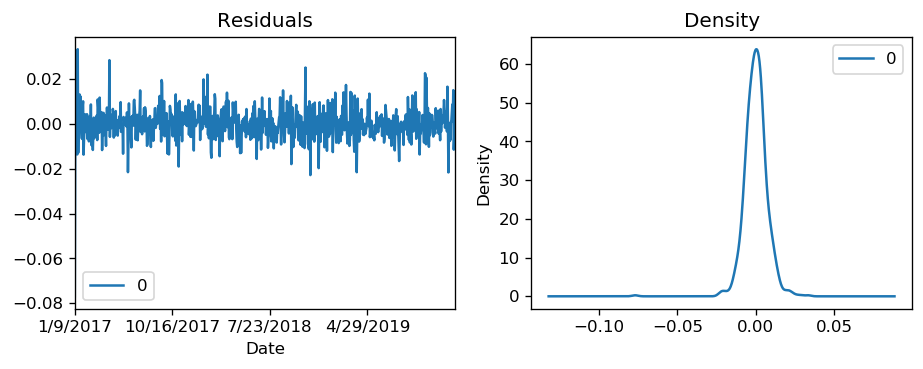

In [746]:
# Plot residual errors
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

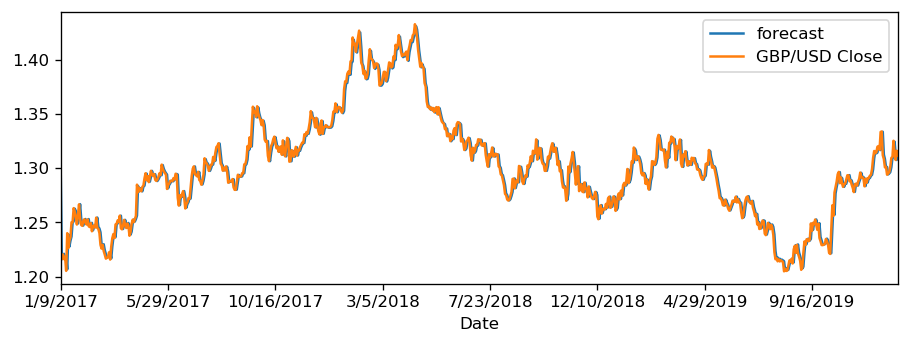

In [747]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [748]:
# Create Training and Test
train = (val[:750])
test = (val[750:])

In [749]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mse = np.mean((forecast - actual)**2)       # MSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'mse':mse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


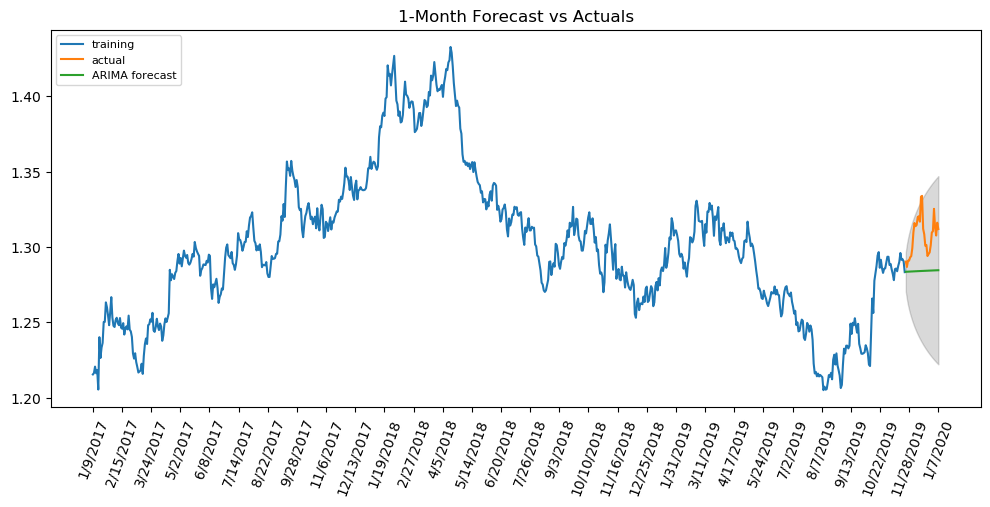

In [753]:
# Build Model
model = ARIMA(train, order=(3, 0, 1))
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(31, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='ARIMA forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('1-Month Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(ticks = None, rotation=70)
plt.xticks(np.linspace(0, 780, 30))
plt.show()

### ARIMA model accuracy

In [756]:
forecast_accuracy(fc_series, test)
# {'mape': 0.017684210855618318,
#  'me': -0.023231980024131203,
#  'mae': 0.023231980024131203,
#  'mpe': -0.017684210855618318,
#  'rmse': 0.026258310527333042,
#  'mse': 0.0006894988717498493,
#  'acf1': 0.783094320840282,
#  'corr': 0.37577753688631865,
#  'minmax': 0.017684210855618554}

{'mape': 0.017684210855618318,
 'me': -0.023231980024131203,
 'mae': 0.023231980024131203,
 'mpe': -0.017684210855618318,
 'rmse': 0.026258310527333042,
 'mse': 0.0006894988717498493,
 'acf1': 0.783094320840282,
 'corr': 0.37577753688631865,
 'minmax': 0.017684210855618554}

### RANDOM WALK model

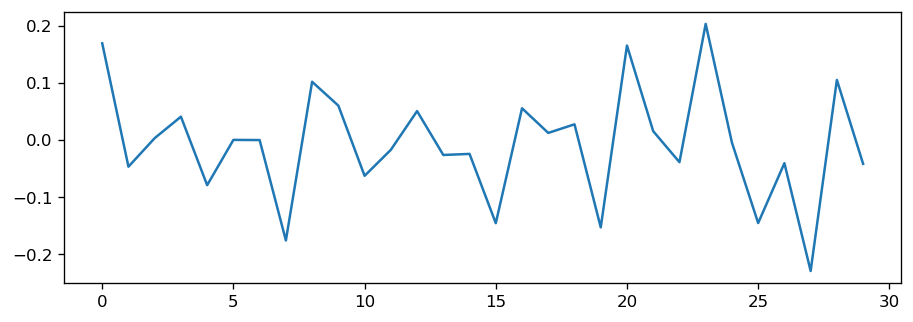

In [757]:
np.random.seed(7)
r = (np.random.randn(1, 1, 30))/10
r = r[0][0]
r = list(r)
plt.plot(r);

### Function to generate random walk series

In [768]:
def rwalk(num, rr):
    rw = [num]
    for i in rr:
        rw.append(rw[-1]+i/10)
    return list(rw)

pr = rwalk(train[-1], r);

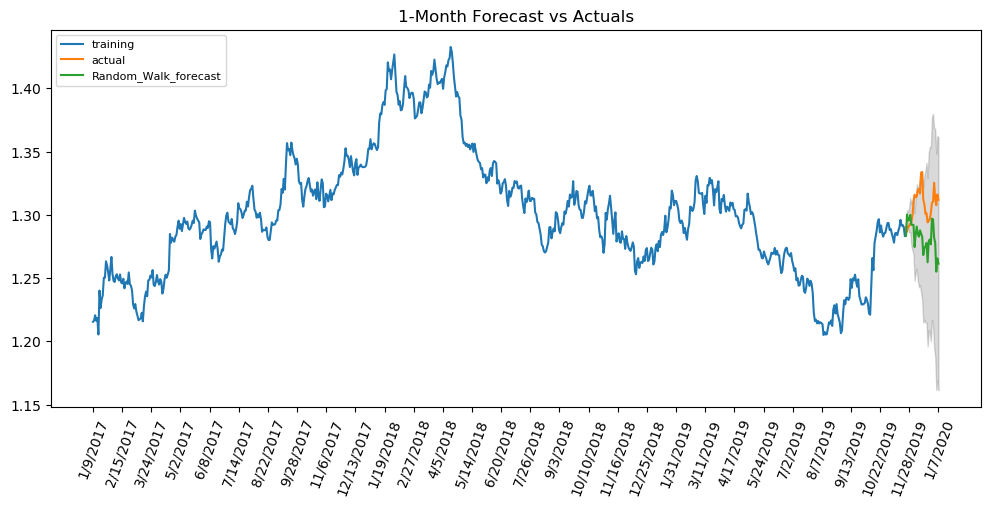

In [769]:
# # Build Model

# Make as pandas series
confed = [np.linspace(0, 0.1, 31)]

fc_series = pd.Series(pr, index=test.index)
lower_series = pd.Series(confed[0]+pr, index=test.index)
upper_series = pd.Series(-1*confed[0]+pr, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='Random_Walk_forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('1-Month Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(ticks = None, rotation=70)
plt.xticks(np.linspace(0, 780, 30))

plt.show()

### RANDOM WALK model accuracy

In [771]:
forecast_accuracy(fc_series, test)
# {'mape': 0.02049177304610476,
#  'me': -0.0249660464227378,
#  'mae': 0.02689988339946853,
#  'mpe': -0.018992098968734446,
#  'rmse': 0.0311358575659974,
#  'mse': 0.0009694416263700777,
#  'acf1': 0.783094320840282,
#  'corr': -0.21048143225921842,
#  'minmax': 0.0204864625113671}

{'mape': 0.02049177304610476,
 'me': -0.0249660464227378,
 'mae': 0.02689988339946853,
 'mpe': -0.018992098968734446,
 'rmse': 0.0311358575659974,
 'mse': 0.0009694416263700777,
 'acf1': 0.783094320840282,
 'corr': -0.21048143225921842,
 'minmax': 0.0204864625113671}

## 6-Month Horizon Forecast

### ARIMA MODEL

In [772]:
# Create Training and Test for 6 month horizon forecast
train = (val[:600])
test = (val[600:])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


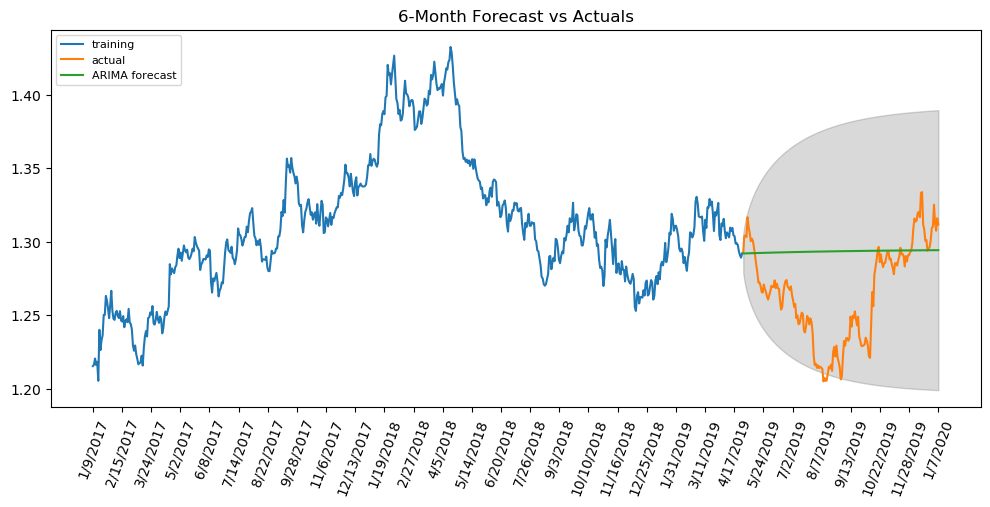

In [773]:
# Build Model
model = ARIMA(train, order=(3, 0, 1))
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(181, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='ARIMA forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('6-Month Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(ticks = None, rotation=70)
plt.xticks(np.linspace(0, 780, 30))
plt.show()

In [775]:
forecast_accuracy(fc_series, test)
# {'mape': 0.0276083016926635,
#  'me': 0.02821529231061567,
#  'mae': 0.03429554461156443,
#  'mpe': 0.02298436246323005,
#  'rmse': 0.04314993435532277,
#  'mse': 0.0018619168348686646,
#  'acf1': 0.9733003303141736,
#  'corr': 0.15656626187301864,
#  'minmax': 0.0264761241269994}

{'mape': 0.0276083016926635,
 'me': 0.02821529231061567,
 'mae': 0.03429554461156443,
 'mpe': 0.02298436246323005,
 'rmse': 0.04314993435532277,
 'mse': 0.0018619168348686646,
 'acf1': 0.9733003303141736,
 'corr': 0.15656626187301864,
 'minmax': 0.0264761241269994}

### RANDOM WALK model

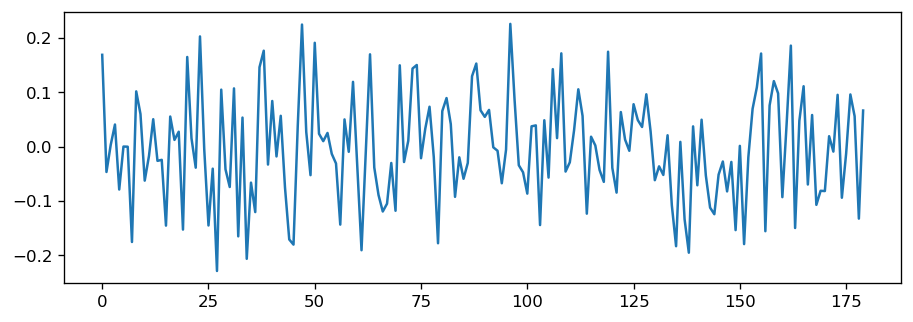

In [776]:
np.random.seed(7)
r = (np.random.randn(1, 1, 180))/10
r = r[0][0]
r = list(r)
plt.plot(r);

In [777]:
pr = rwalk(train[-1], r);

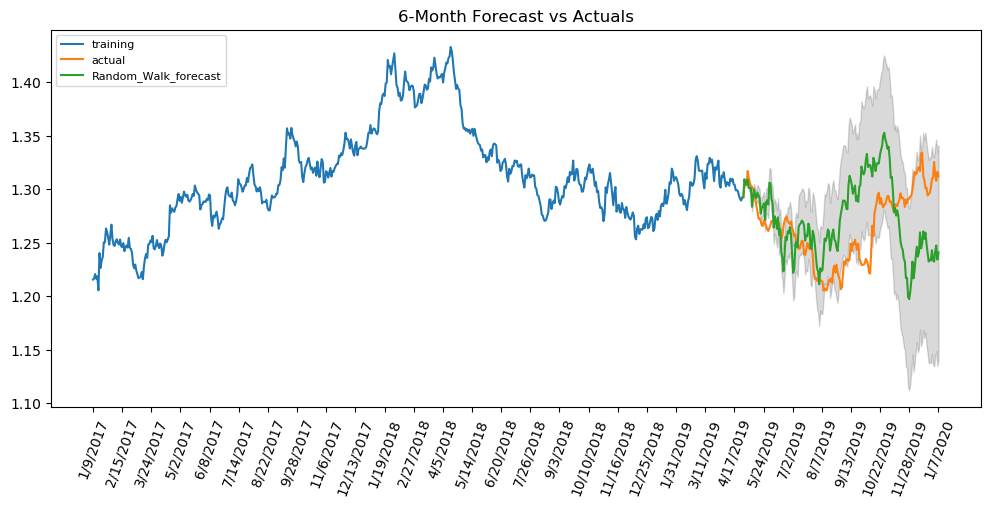

In [778]:
# # Build Model
# model = ARIMA(train, order=(11, 1, 0))
# fitted = model.fit(disp=-1)  

# # Forecast
# fc, se, conf = fitted.forecast(31, alpha=0.05)  # 95% conf

# Make as pandas series
confed = [np.linspace(0, 0.1, 181)]

fc_series = pd.Series(pr, index=test.index)
lower_series = pd.Series(confed[0]+pr, index=test.index)
upper_series = pd.Series(-1*confed[0]+pr, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='Random_Walk_forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('6-Month Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(ticks = None, rotation=70)
plt.xticks(np.linspace(0, 780, 30))

plt.show()

In [779]:
forecast_accuracy(fc_series, test)
# {'mape': 0.031113040838125963,
#  'me': 0.007041552299545313,
#  'mae': 0.039395628080756015,
#  'mpe': 0.006242609671456182,
#  'rmse': 0.04851525879117457,
#  'mse': 0.002353730335574641,
#  'acf1': 0.9733003303141736,
#  'corr': -0.0094746675617198,
#  'minmax': 0.03031439001883085}

{'mape': 0.031113040838125963,
 'me': 0.007041552299545313,
 'mae': 0.039395628080756015,
 'mpe': 0.006242609671456182,
 'rmse': 0.04851525879117457,
 'mse': 0.002353730335574641,
 'acf1': 0.9733003303141736,
 'corr': -0.0094746675617198,
 'minmax': 0.03031439001883085}